pip install scikit-learn


In [1]:
import pathlib
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import cv2

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [29]:
data_dir = Path('E:/Rem/nutritionapp/dataset/Food Classification dataset/')

In [30]:
filepaths = list(data_dir.glob(r'**/*.jpg'))
label =list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [31]:
filepaths = pd.Series(filepaths, name = 'filepaths').astype(str)
labels = pd.Series(label, name = 'label')
images = pd.concat([filepaths, labels], axis =1)

In [33]:

categories_sample = []
for category in images['label'].unique():
    category_slice = images.query("label == @category")
    sample_size = min(100, len(category_slice))  # Adjust sample size
    categories_sample.append(category_slice.sample(sample_size, random_state=1))

image_df = pd.concat(categories_sample, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

    

image_df['label'].value_counts()

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
train_df, test_df = train_test_split(image_df, train_size=0.75, shuffle=True, random_state=1)

In [36]:
train_df

,filepaths,label
683,E:\Rem\nutritionapp\dataset\Food Classificatio...,fried_rice
1017,E:\Rem\nutritionapp\dataset\Food Classificatio...,fried_rice
685,E:\Rem\nutritionapp\dataset\Food Classificatio...,pizza
958,E:\Rem\nutritionapp\dataset\Food Classificatio...,ice_cream
726,E:\Rem\nutritionapp\dataset\Food Classificatio...,butter_naan
...,...,...
960,E:\Rem\nutritionapp\dataset\Food Classificatio...,cheesecake
847,E:\Rem\nutritionapp\dataset\Food Classificatio...,cheesecake
715,E:\Rem\nutritionapp\dataset\Food Classificatio...,apple_pie
905,E:\Rem\nutritionapp\dataset\Food Classificatio...,Hot Dog


In [37]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
)

In [52]:
num_classes = len(train_images.class_indices)
num_classes

11

In [61]:
train_images.class_indices

{'Donut': 0,
 'Hot Dog': 1,
 'apple_pie': 2,
 'burger': 3,
 'butter_naan': 4,
 'cheesecake': 5,
 'chicken_curry': 6,
 'fried_rice': 7,
 'ice_cream': 8,
 'omelette': 9,
 'pizza': 10}

In [38]:
train_images= train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images=test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
   
)

Found 633 validated image filenames belonging to 11 classes.
Found 158 validated image filenames belonging to 11 classes.
Found 264 validated image filenames belonging to 11 classes.


In [46]:
from tensorflow.keras.applications import MobileNetV2

In [47]:
mobile_model= tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    
)
mobile_model.trainable= False

In [53]:
inputs= mobile_model.input
x= tf.keras.layers.Dense(128, activation='relu')(mobile_model.output)
x= tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model= tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [54]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [55]:
import scipy

# Your code here
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)


Epoch 1/20
20/20 [==============================] - 13s 546ms/step - loss: 1.7991 - accuracy: 0.4502 - val_loss: 0.9673 - val_accuracy: 0.7405
Epoch 2/20
20/20 [==============================] - 6s 306ms/step - loss: 0.6402 - accuracy: 0.8136 - val_loss: 0.6114 - val_accuracy: 0.7911
Epoch 3/20
20/20 [==============================] - 6s 309ms/step - loss: 0.3178 - accuracy: 0.9115 - val_loss: 0.5580 - val_accuracy: 0.8038
Epoch 4/20
20/20 [==============================] - 6s 315ms/step - loss: 0.1858 - accuracy: 0.9510 - val_loss: 0.4837 - val_accuracy: 0.8481
Epoch 5/20
20/20 [==============================] - 6s 300ms/step - loss: 0.1213 - accuracy: 0.9779 - val_loss: 0.4768 - val_accuracy: 0.8418
Epoch 6/20
20/20 [==============================] - 6s 307ms/step - loss: 0.0617 - accuracy: 0.9921 - val_loss: 0.4577 - val_accuracy: 0.8544
Epoch 7/20
20/20 [==============================] - 6s 297ms/step - loss: 0.0327 - accuracy: 1.0000 - val_loss: 0.4168 - val_accuracy: 0.8544
Epoch

In [56]:
results= model.evaluate(test_images, verbose=0)
print("accuracy: {:.2f}%".format(results[1] * 100))

accuracy: 79.17%


In [57]:
from sklearn.metrics import confusion_matrix, classification_report

predictions = np.argmax(model.predict(test_images), axis=1)

cm= confusion_matrix(test_images.labels, predictions)
ca= classification_report(test_images.labels, predictions , target_names=test_images.class_indices)

9/9 [==============================] - 3s 205ms/step


pip install seaborn

In [58]:
import seaborn as sns

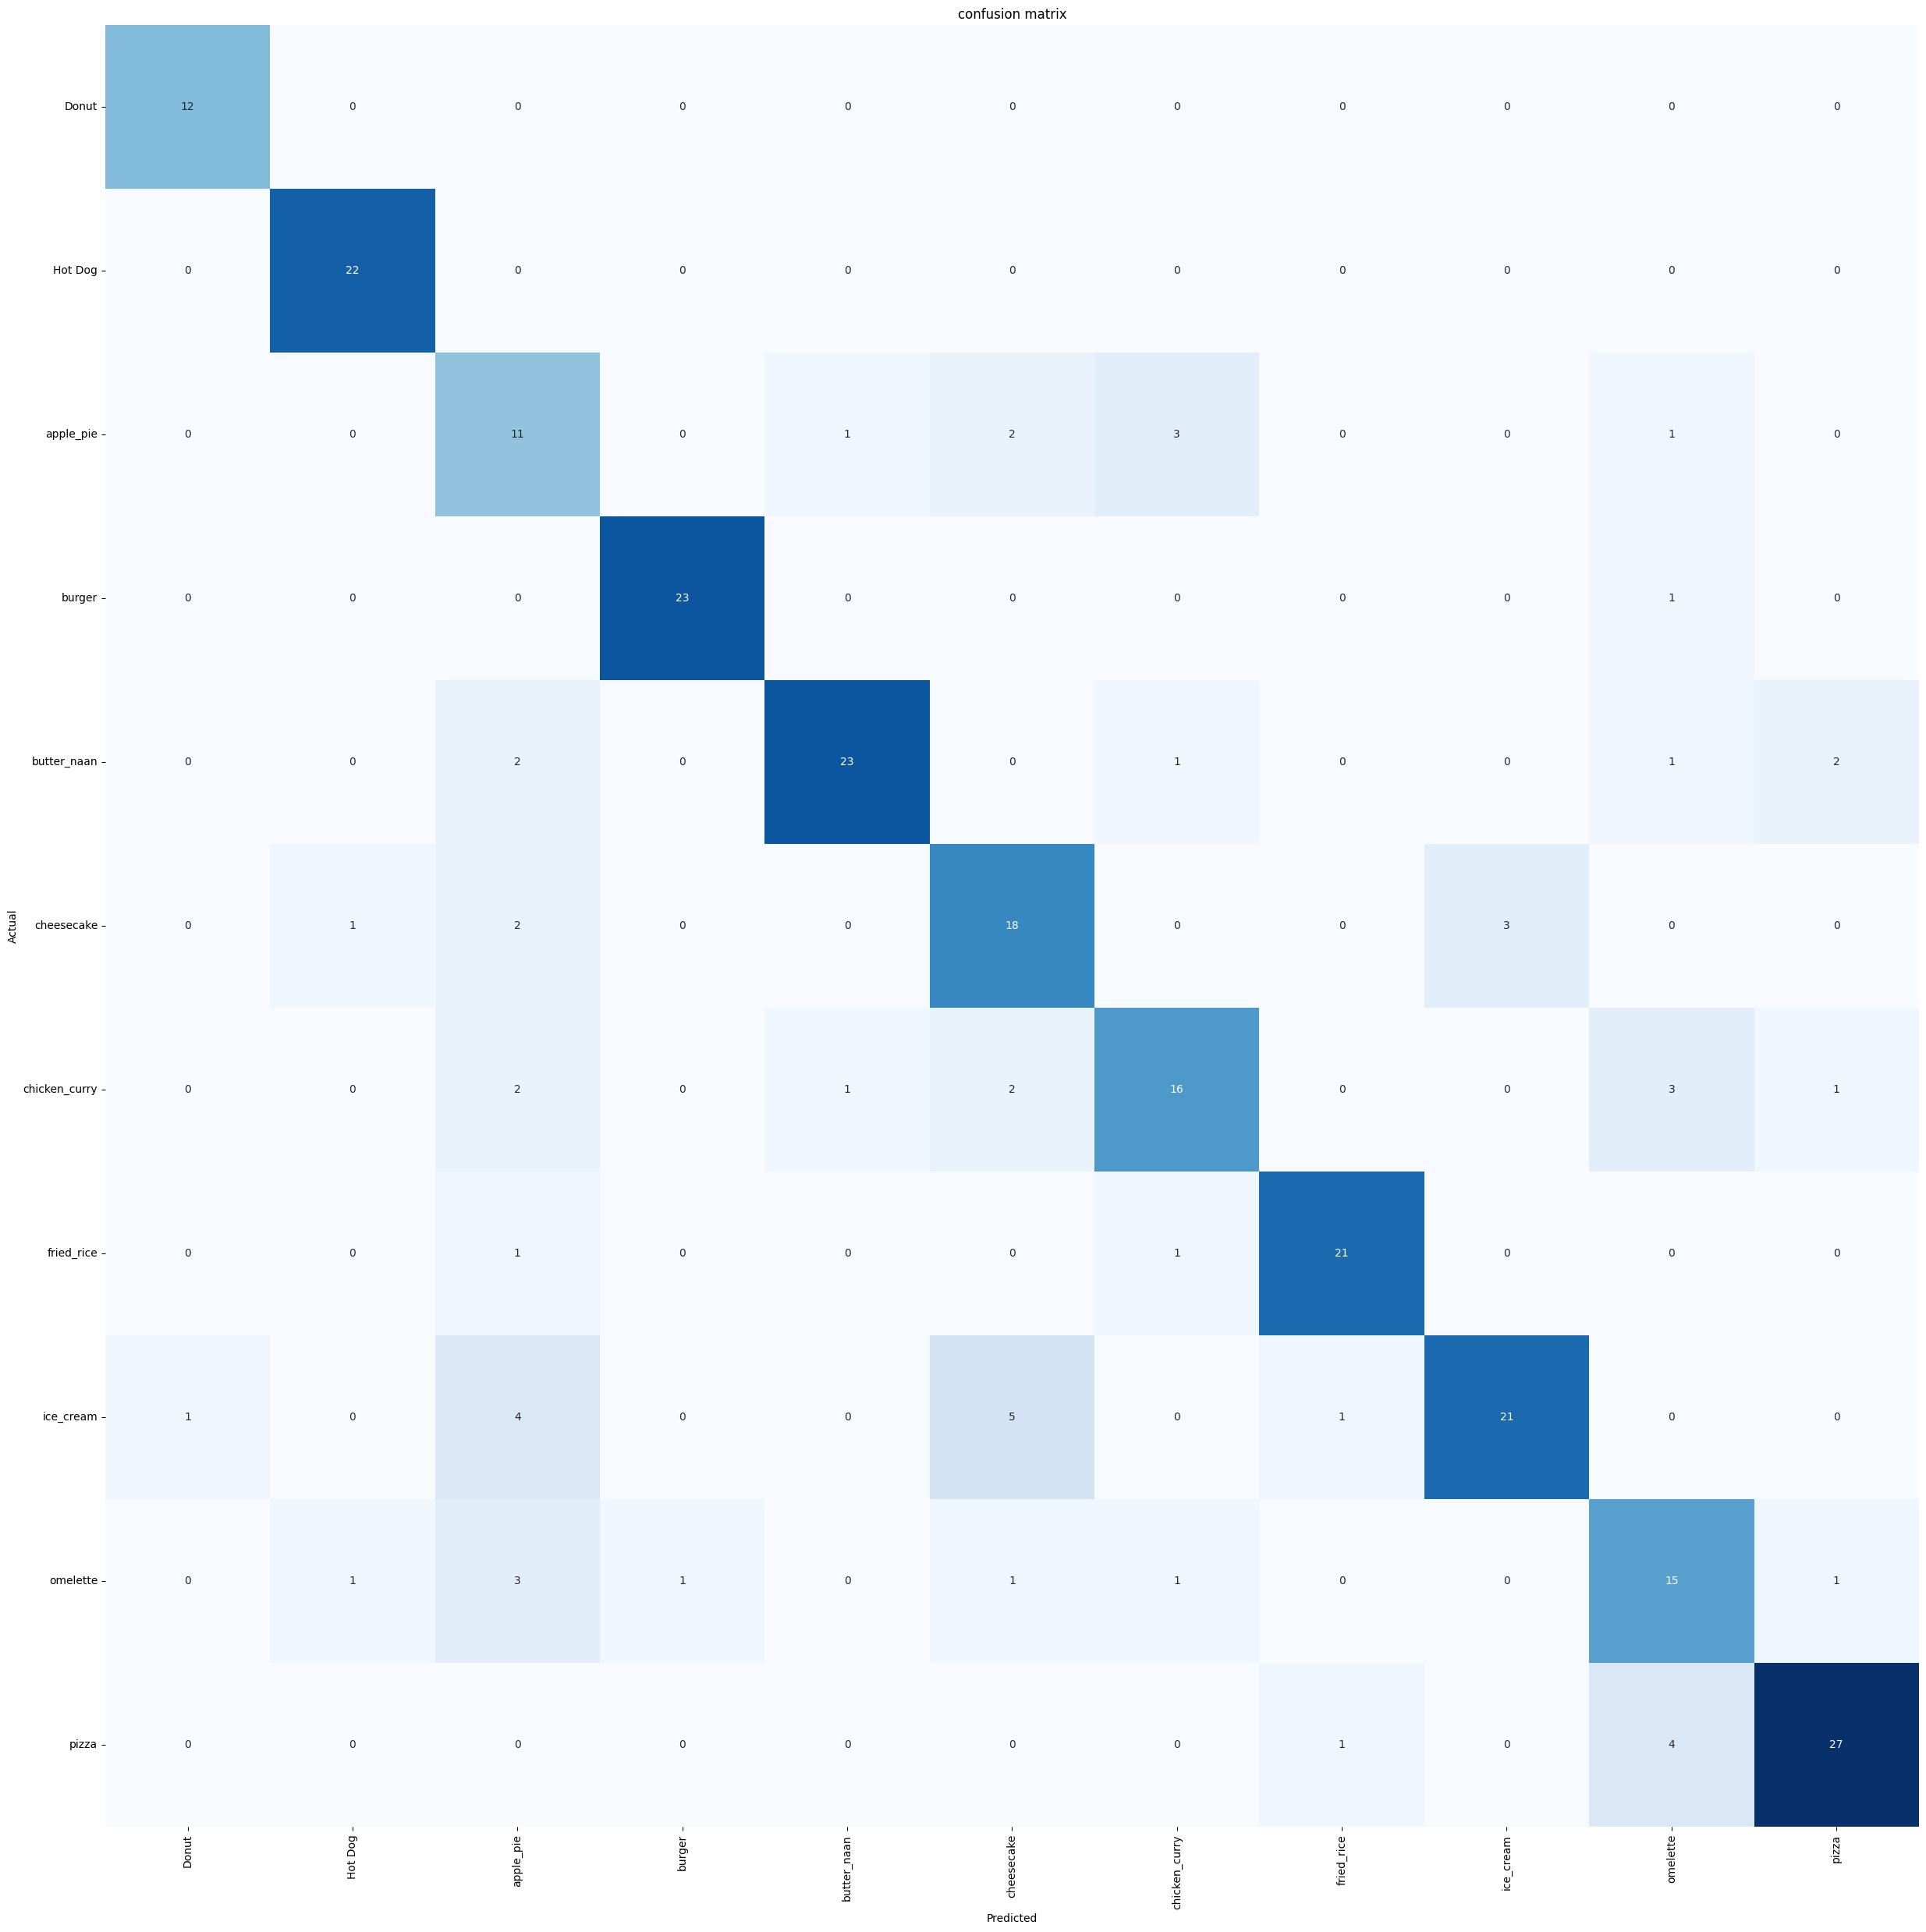

In [60]:
plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar= False )
plt.xticks(ticks=np.arange(11) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(11) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("confusion matrix")
plt.show()


In [ ]:
print("classification report", ca)

In [18]:
from tensorflow.keras.preprocessing import image
from PIL import Image
image_path = r"E:\Rem\nutritionapp\UECFOOD100\tempura\5397.jpg"
img = Image.open(image_path)

In [19]:
from tensorflow.keras.preprocessing import image

# Resize and preprocess the image
img = img.resize((224, 224))  # Assuming your model expects input size 224x224
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension


In [20]:
# Assuming model is already trained and loaded
predictions = model.predict(img_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [65]:
class_labels = {
    0: 'Donut',
    1: 'Hot Dog',
    2: 'apple_pie',
    3: 'burger',
    4: 'butter_naan',
    5: 'cheesecake',
    6: 'chicken_curry',
    7: 'fried_rice',
    8: 'ice_cream',
    9: 'omelette',
    10: 'pizza'
}
# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]


In [66]:
print("Predicted Class Label:", predicted_class_label)


Predicted Class Label: ice_cream


In [ ]:
import cv2

# Initialize the webcam
cap = cv2.VideoCapture(0)  

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        print("Error: Failed to capture frame")
        breakq
    
    
    resized_frame = cv2.resize(frame, (224, 224))
    # Convert BGR to RGB
    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    # Normalize pixel values to range [0, 1]
    normalized_frame = rgb_frame / 255.0
    
    
    input_data = np.expand_dims(normalized_frame, axis=0)

    # Predict using the model
    predictions = model.predict(input_data)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)

    # Get the predicted class label
    predicted_class_label = class_labels[predicted_class_index]

    # Display the frame with the predicted class label
    cv2.putText(frame, predicted_class_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Frame', frame)

    # Exit loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 25ms/step
